# Convolution Autoencoders (CAE)

Import the libraries

In [28]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image

from os.path import exists

Utility functions, to store the temporary images and to convert matrix shape.

In [29]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Dataset

In [30]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

# Transforms images to a PyTorch Tensor
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data", train = True,download = True,transform = img_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,batch_size = batch_size,shuffle = True)

## Model

In [31]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [32]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16,8,3),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8,3,3),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(3,16,3),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(16,1,3),
            torch.nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [33]:
# Model Initialization
model = AE()
#moving to gpu
model.to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate,weight_decay = 1e-5)

## Training/Loading

In [34]:
model_file = "cae_3.pth"

In [36]:
if exists(model_file):
    model.load_state_dict(torch.load(model_file))
    model.eval()
else:
    losses = []
    for epoch in range(num_epochs):
        for data in loader:
            image, label = data

            # Reshaping the image to (-1, 784)
#            image = image.view(image.size(0), -1)
            #image = image.reshape(-1, 28*28)

            # Output of Autoencoder
            image = image.to(device)

            _,reconstructed = model(image)

            # Calculating the loss function
            loss = loss_function(reconstructed, image)

            # The gradients are set to zero,
            # the the gradient is computed and stored.
            # .step() performs parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Storing the losses in a list for plotting
            losses.append(loss)
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))
        if epoch % 10 == 0:
            pic = to_img(reconstructed.cpu().data)
            save_image(pic, './mlp_img/image_{}.png'.format(epoch))

    torch.save(model.state_dict(), model_file)
    model.eval()
    # Defining the Plot Style
    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    # Plotting the last 100 values
    plt.plot(losses[-100:])

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128, 1, 28, 28])) that is different to the input size (torch.Size([128, 1, 6, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (6) must match the size of tensor b (28) at non-singleton dimension 3

## Display sample images

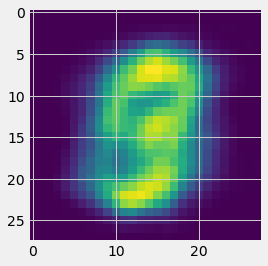

In [29]:
import random
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
model.eval()
model.to("cpu")
fig = plt.figure(figsize=(20., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


for i in range(10):
    image,_ = dataset.__getitem__(random.randint(1,37000))

    img = image.reshape(-1, 28*28)
    _,reconstructed = model(img)
    item = reconstructed.reshape(-1, 28, 28)
    item = item.detach().numpy()

    # Iterating over the grid returns the Axes.
    grid[i].imshow(image[0])
    grid[i].grid(False)
    grid[10+i].imshow(item[0])
    grid[10+i].grid(False)


plt.savefig("cae_nums.png",transparent=True)
plt.show()